In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_15_13_46
NN-MODEL FILENAME:  ./models/STI6WR1Z_15_13_46_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 30
LO_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  30


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                                                                 C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]
    ###############################################
#     LENGTH_MAX = length_mean + 0.05
#     LENGTH_MIN = length_mean - 0.05
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(node_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.075, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.075, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])



# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
np.save(node_QFILE, init_q_table)

peak memory: 11227.29 MiB, increment: 10158.26 MiB
Quantization TIME:  0.09 minutes


In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 20254 EXPERIENCES:0:00:02.547775


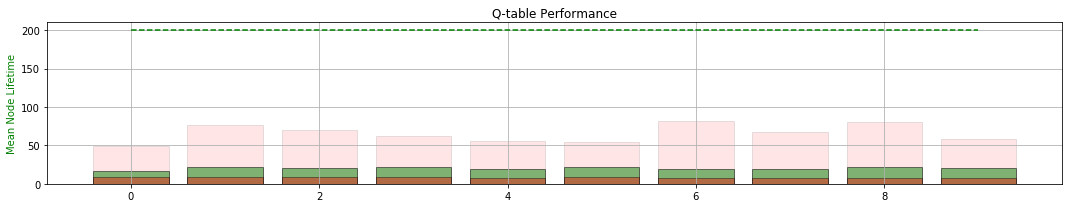

GOOD MEMORY COUNTER:  19254
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.37
Validating... MEAN TIME:  129.535
Validating... MEAN TIME:  146.55
Validating... MEAN TIME:  153.03
Validating... MEAN TIME:  135.085
TRAINING TIME:0:00:37.253449


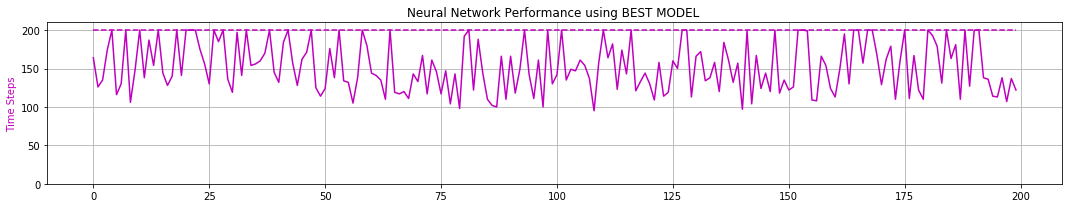

0 -max- [ 0.445  2.313  0.209  1.870  0.550]
0 -min- [-0.157 -1.199 -0.209 -2.961  0.375]

1 -max- [ 0.510  1.951  0.209  2.123  0.600]
1 -min- [-0.408 -1.396 -0.209 -2.486  0.402]

2 -max- [ 0.549  2.848  0.208  1.746  0.650]
2 -min- [-0.351 -1.196 -0.209 -3.165  0.450]

3 -max- [ 0.871  2.607  0.209  1.954  0.699]
3 -min- [-0.160 -1.210 -0.209 -2.723  0.500]

4 -max- [ 0.507  2.528  0.207  2.108  0.749]
4 -min- [-0.474 -1.480 -0.209 -3.203  0.550]

5 -max- [ 0.406  1.910  0.209  2.503  0.800]
5 -min- [-0.222 -1.786 -0.209 -2.732  0.600]

6 -max- [ 0.519  1.987  0.205  1.603  0.850]
6 -min- [-1.021 -1.720 -0.209 -2.837  0.650]

7 -max- [ 0.369  2.053  0.209  2.181  0.900]
7 -min- [-0.811 -2.428 -0.209 -2.860  0.701]

8 -max- [ 0.637  2.706  0.204  2.159  0.925]
8 -min- [-0.175 -1.206 -0.209 -2.760  0.751]

9 -max- [ 0.298  1.913  0.209  2.701  0.925]
9 -min- [-0.591 -1.781 -0.209 -2.747  0.801]

peak memory: 12322.75 MiB, increment: 10196.57 MiB
Quantization TIME:  0.1 minutes


ITERA

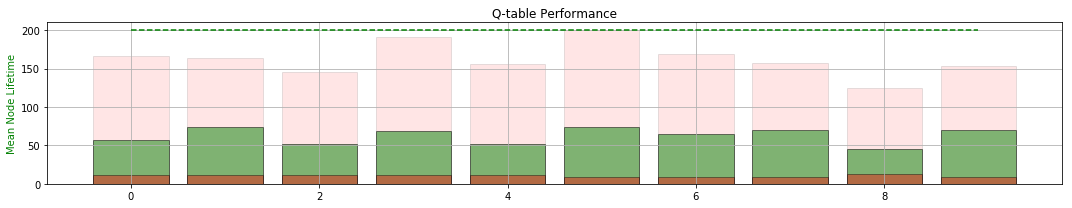

GOOD MEMORY COUNTER:  80884
BAD MEMORY COUNTER:  1999
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  185.585
Validating... MEAN TIME:  188.555
Validating... MEAN TIME:  183.21
Validating... MEAN TIME:  190.12
Validating... MEAN TIME:  199.06
TRAINING TIME:0:00:47.080650


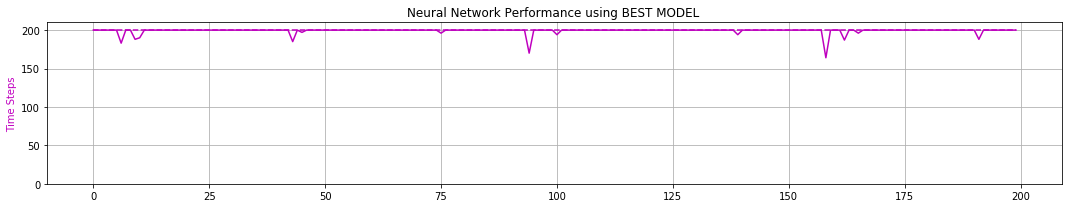

0 -max- [ 0.778  1.731  0.208  2.204  0.550]
0 -min- [-0.868 -1.923 -0.209 -2.320  0.375]

1 -max- [ 0.829  1.524  0.209  1.996  0.599]
1 -min- [-1.044 -2.025 -0.209 -2.292  0.401]

2 -max- [ 0.659  1.339  0.209  2.215  0.650]
2 -min- [-1.398 -2.207 -0.209 -2.576  0.451]

3 -max- [ 0.937  1.551  0.209  2.103  0.700]
3 -min- [-1.041 -2.020 -0.209 -2.018  0.500]

4 -max- [ 0.509  1.790  0.209  2.519  0.750]
4 -min- [-1.418 -2.202 -0.209 -2.673  0.550]

5 -max- [ 0.664  1.696  0.208  1.815  0.800]
5 -min- [-1.477 -2.063 -0.209 -2.189  0.601]

6 -max- [ 0.724  1.877  0.209  2.216  0.850]
6 -min- [-1.160 -2.120 -0.209 -2.440  0.651]

7 -max- [ 0.974  1.830  0.208  2.888  0.899]
7 -min- [-1.221 -2.536 -0.209 -2.438  0.700]

8 -max- [ 1.046  2.296  0.209  2.466  0.925]
8 -min- [-1.026 -2.154 -0.209 -2.741  0.750]

9 -max- [ 1.053  1.703  0.209  2.735  0.925]
9 -min- [-1.548 -2.259 -0.209 -2.100  0.801]

peak memory: 12616.58 MiB, increment: 10377.18 MiB
Quantization TIME:  0.1 minutes


ITERA

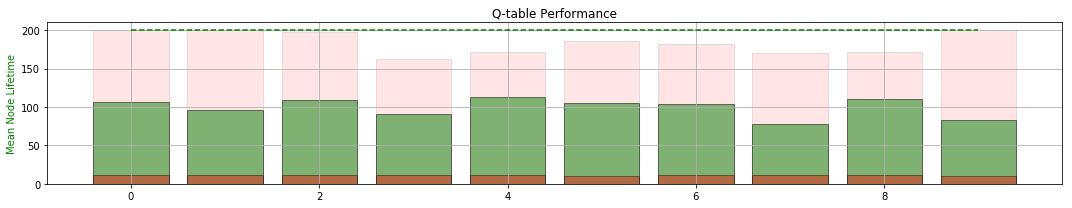

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2996
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  186.99
Validating... MEAN TIME:  182.775
Validating... MEAN TIME:  171.85
Validating... MEAN TIME:  158.845
Validating... MEAN TIME:  145.135
TRAINING TIME:0:00:43.264812


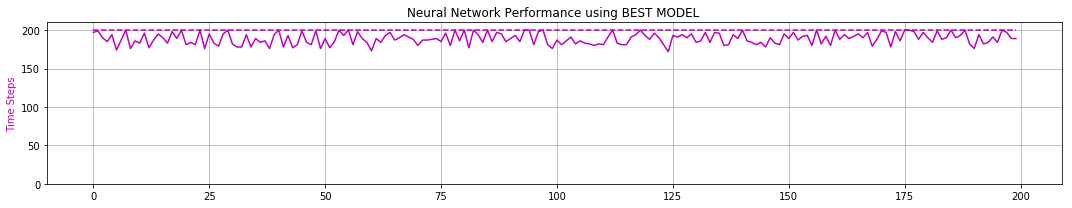

0 -max- [ 0.196  1.129  0.204  1.637  0.550]
0 -min- [-2.397 -2.914 -0.209 -1.701  0.375]

1 -max- [ 1.220  1.401  0.209  1.704  0.600]
1 -min- [-2.104 -2.810 -0.209 -1.927  0.401]

2 -max- [ 1.296  1.467  0.207  1.750  0.649]
2 -min- [-2.358 -2.788 -0.209 -1.973  0.450]

3 -max- [ 0.237  1.336  0.208  1.546  0.699]
3 -min- [-2.365 -2.881 -0.209 -2.216  0.500]

4 -max- [ 0.182  1.516  0.208  1.611  0.749]
4 -min- [-2.360 -2.911 -0.209 -2.177  0.550]

5 -max- [ 0.400  1.581  0.209  1.686  0.800]
5 -min- [-2.136 -2.602 -0.209 -1.975  0.602]

6 -max- [ 0.437  1.034  0.202  1.498  0.849]
6 -min- [-2.202 -2.590 -0.209 -1.996  0.651]

7 -max- [ 1.746  2.033  0.208  2.283  0.900]
7 -min- [-1.711 -2.244 -0.209 -2.149  0.700]

8 -max- [ 0.156  1.154  0.208  2.261  0.925]
8 -min- [-2.089 -2.393 -0.209 -1.952  0.751]

9 -max- [ 0.516  1.481  0.208  2.422  0.925]
9 -min- [-2.357 -2.586 -0.209 -2.521  0.800]

peak memory: 12457.97 MiB, increment: 10178.09 MiB
Quantization TIME:  0.1 minutes


ITERA

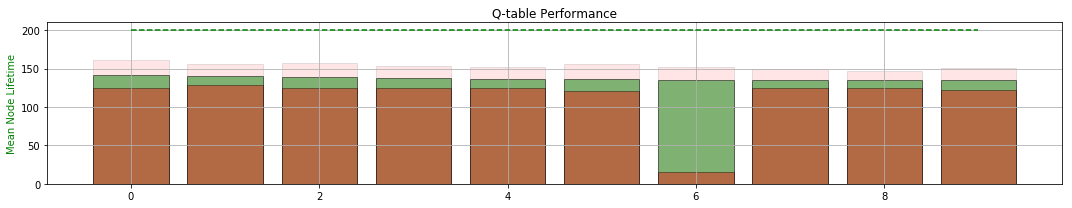

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  131.84
Validating... MEAN TIME:  137.665
Validating... MEAN TIME:  138.635
Validating... MEAN TIME:  136.27
Validating... MEAN TIME:  152.045
TRAINING TIME:0:00:37.653301


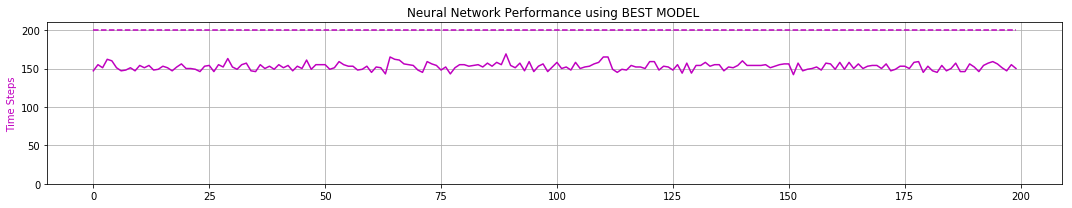

0 -max- [ 0.144  0.990  0.050  1.010  0.549]
0 -min- [-2.400 -2.449 -0.134 -1.384  0.375]

1 -max- [ 0.137  0.807  0.048  1.043  0.599]
1 -min- [-2.400 -2.441 -0.156 -1.336  0.400]

2 -max- [ 0.126  0.798  0.049  1.892  0.650]
2 -min- [-2.400 -3.206 -0.150 -1.210  0.451]

3 -max- [ 0.141  0.824  0.050  1.299  0.700]
3 -min- [-2.400 -2.656 -0.168 -1.215  0.500]

4 -max- [ 0.137  0.822  0.057  1.512  0.750]
4 -min- [-2.400 -2.840 -0.140 -1.319  0.550]

5 -max- [ 0.137  0.824  0.049  1.207  0.800]
5 -min- [-2.400 -2.641 -0.174 -1.240  0.600]

6 -max- [ 0.147  0.979  0.049  0.985  0.850]
6 -min- [-2.399 -2.455 -0.199 -1.366  0.652]

7 -max- [ 0.156  0.816  0.048  0.888  0.900]
7 -min- [-2.400 -2.419 -0.150 -1.188  0.701]

8 -max- [ 0.160  0.825  0.050  0.944  0.925]
8 -min- [-2.400 -2.446 -0.174 -1.240  0.750]

9 -max- [ 0.155  0.828  0.049  1.129  0.925]
9 -min- [-2.400 -2.554 -0.173 -1.246  0.802]

peak memory: 12341.30 MiB, increment: 10011.08 MiB
Quantization TIME:  0.1 minutes


ITERA

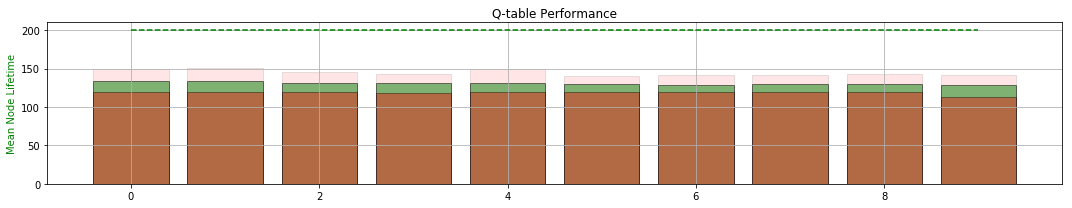

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  150.325
Validating... MEAN TIME:  150.03
Validating... MEAN TIME:  129.985
Validating... MEAN TIME:  129.545
Validating... MEAN TIME:  139.96
TRAINING TIME:0:00:37.630508


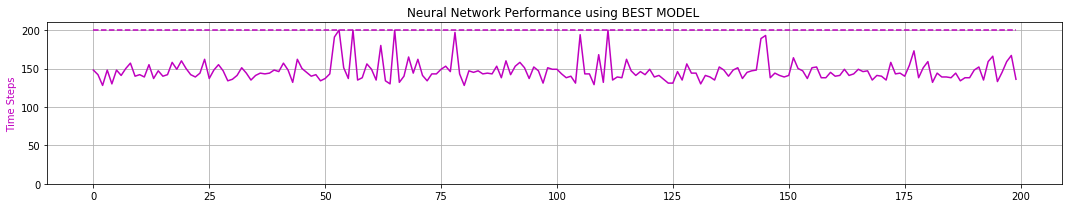

0 -max- [ 0.123  0.624  0.048  0.739  0.550]
0 -min- [-2.400 -2.726 -0.181 -0.913  0.375]

1 -max- [ 0.123  0.822  0.049  0.736  0.599]
1 -min- [-2.400 -2.615 -0.177 -1.110  0.401]

2 -max- [ 0.131  0.633  0.050  0.723  0.650]
2 -min- [-2.399 -2.799 -0.166 -0.960  0.451]

3 -max- [ 0.117  0.634  0.050  0.707  0.699]
3 -min- [-2.400 -2.598 -0.172 -0.934  0.500]

4 -max- [ 0.131  0.822  0.049  0.735  0.750]
4 -min- [-2.399 -2.581 -0.177 -1.151  0.550]

5 -max- [ 0.134  0.765  0.049  0.782  0.800]
5 -min- [-2.400 -2.607 -0.182 -1.155  0.600]

6 -max- [ 0.143  0.634  0.048  0.726  0.850]
6 -min- [-2.400 -2.582 -0.162 -0.917  0.650]

7 -max- [ 0.126  0.826  0.050  0.725  0.899]
7 -min- [-2.399 -2.736 -0.179 -1.204  0.700]

8 -max- [ 0.151  0.732  0.049  0.717  0.925]
8 -min- [-2.399 -2.600 -0.160 -1.114  0.750]

9 -max- [ 0.144  0.809  0.048  0.738  0.925]
9 -min- [-2.400 -2.603 -0.152 -1.225  0.800]

peak memory: 12431.70 MiB, increment: 10099.46 MiB
Quantization TIME:  0.1 minutes


ITERA

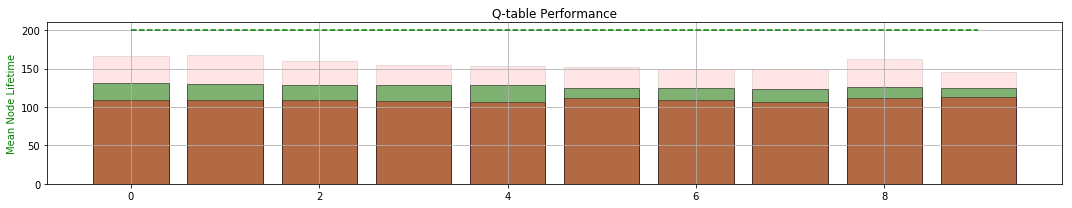

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.93
Validating... MEAN TIME:  160.1
Validating... MEAN TIME:  135.9
Validating... MEAN TIME:  115.81
Validating... MEAN TIME:  126.79
TRAINING TIME:0:00:37.267072


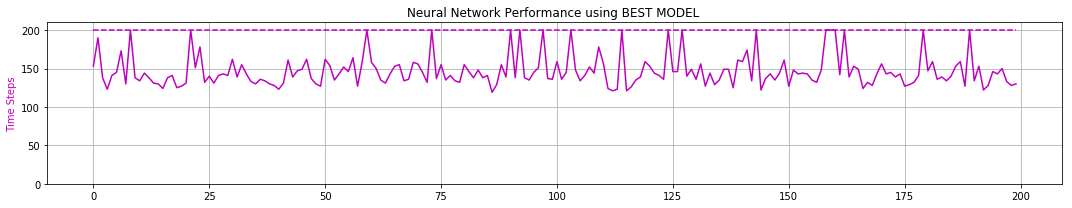

0 -max- [ 0.151  0.788  0.049  0.722  0.550]
0 -min- [-2.399 -2.985 -0.200 -1.097  0.375]

1 -max- [ 0.172  0.629  0.050  0.682  0.600]
1 -min- [-2.399 -2.932 -0.191 -0.906  0.400]

2 -max- [ 0.140  0.610  0.050  0.705  0.648]
2 -min- [-2.399 -2.804 -0.177 -0.881  0.450]

3 -max- [ 0.150  0.629  0.049  0.702  0.700]
3 -min- [-2.399 -2.962 -0.202 -0.928  0.500]

4 -max- [ 0.147  0.631  0.049  0.740  0.750]
4 -min- [-2.400 -2.949 -0.196 -0.990  0.550]

5 -max- [ 0.149  0.625  0.048  0.689  0.800]
5 -min- [-2.400 -2.891 -0.189 -0.886  0.600]

6 -max- [ 0.132  0.631  0.050  0.695  0.850]
6 -min- [-2.399 -2.955 -0.197 -0.891  0.650]

7 -max- [ 0.147  0.816  0.049  0.885  0.900]
7 -min- [-2.400 -2.918 -0.188 -1.160  0.700]

8 -max- [ 0.162  0.632  0.048  0.731  0.925]
8 -min- [-2.400 -3.075 -0.193 -0.902  0.750]

9 -max- [ 0.142  0.625  0.049  0.706  0.925]
9 -min- [-2.400 -2.787 -0.176 -0.914  0.800]

peak memory: 12558.65 MiB, increment: 10214.45 MiB
Quantization TIME:  0.1 minutes


ITERA

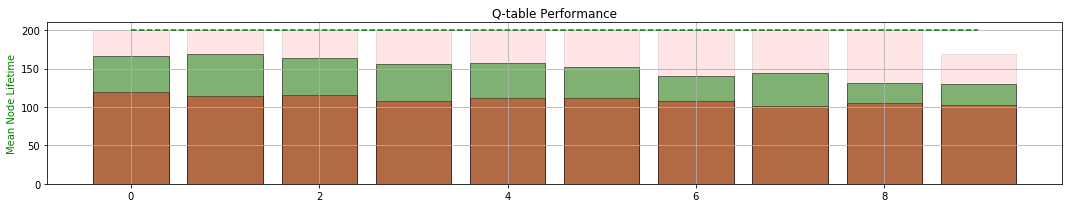

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6835
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  140.435
Validating... MEAN TIME:  163.08
Validating... MEAN TIME:  157.27
Validating... MEAN TIME:  131.32
Validating... MEAN TIME:  131.825
TRAINING TIME:0:00:38.874076


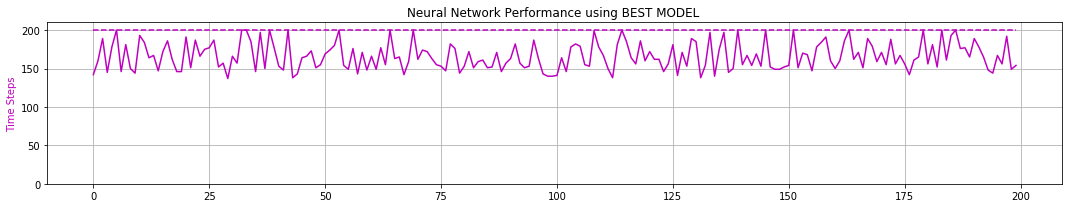

0 -max- [ 2.397  2.947  0.209  0.698  0.550]
0 -min- [-2.398 -3.085 -0.183 -1.114  0.375]

1 -max- [ 2.378  2.419  0.209  0.908  0.599]
1 -min- [-2.399 -2.878 -0.173 -0.861  0.400]

2 -max- [ 2.382  2.779  0.209  0.900  0.650]
2 -min- [-2.398 -2.890 -0.179 -0.856  0.450]

3 -max- [ 2.367  2.780  0.157  0.984  0.700]
3 -min- [-2.399 -2.950 -0.196 -1.157  0.500]

4 -max- [ 1.137  0.960  0.166  0.835  0.748]
4 -min- [-2.400 -2.932 -0.197 -0.886  0.550]

5 -max- [ 0.829  1.678  0.209  0.894  0.800]
5 -min- [-2.399 -3.116 -0.197 -0.884  0.601]

6 -max- [ 0.694  1.838  0.209  0.785  0.850]
6 -min- [-2.400 -3.104 -0.206 -1.082  0.650]

7 -max- [ 0.152  1.328  0.209  0.818  0.899]
7 -min- [-2.400 -3.123 -0.198 -1.179  0.700]

8 -max- [ 0.138  1.334  0.207  0.917  0.925]
8 -min- [-2.400 -3.286 -0.181 -1.122  0.751]

9 -max- [ 0.166  1.659  0.204  0.936  0.925]
9 -min- [-2.400 -3.310 -0.194 -0.998  0.803]

peak memory: 12747.86 MiB, increment: 10378.89 MiB
Quantization TIME:  0.1 minutes


ITERA

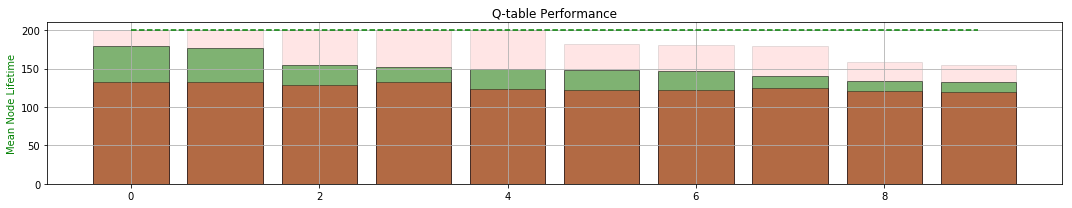

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7756
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  186.675
Validating... MEAN TIME:  164.29
Validating... MEAN TIME:  149.695
Validating... MEAN TIME:  185.09
Validating... MEAN TIME:  156.005
TRAINING TIME:0:00:43.560474


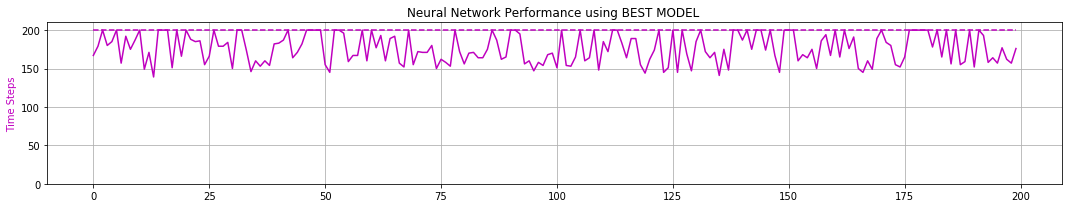

0 -max- [ 0.151  0.630  0.050  0.942  0.549]
0 -min- [-2.399 -2.997 -0.174 -0.998  0.375]

1 -max- [ 0.123  0.803  0.049  0.837  0.599]
1 -min- [-2.400 -2.996 -0.178 -1.148  0.400]

2 -max- [ 0.108  0.632  0.049  0.872  0.650]
2 -min- [-2.400 -2.973 -0.201 -0.981  0.451]

3 -max- [ 0.139  0.816  0.048  0.869  0.700]
3 -min- [-2.399 -2.992 -0.189 -1.170  0.500]

4 -max- [ 0.107  0.780  0.050  1.017  0.750]
4 -min- [-2.398 -3.103 -0.206 -1.156  0.551]

5 -max- [ 0.121  0.815  0.049  0.845  0.799]
5 -min- [-2.399 -3.120 -0.185 -1.062  0.600]

6 -max- [ 0.129  0.806  0.048  0.866  0.849]
6 -min- [-2.400 -3.079 -0.185 -1.108  0.650]

7 -max- [ 0.123  0.772  0.049  1.107  0.900]
7 -min- [-2.400 -3.153 -0.179 -1.132  0.701]

8 -max- [ 0.150  0.995  0.050  0.871  0.925]
8 -min- [-2.398 -3.115 -0.182 -1.391  0.750]

9 -max- [ 0.121  0.819  0.050  0.986  0.925]
9 -min- [-2.399 -3.114 -0.203 -1.197  0.801]

peak memory: 12406.64 MiB, increment: 10033.92 MiB
Quantization TIME:  0.1 minutes


ITERA

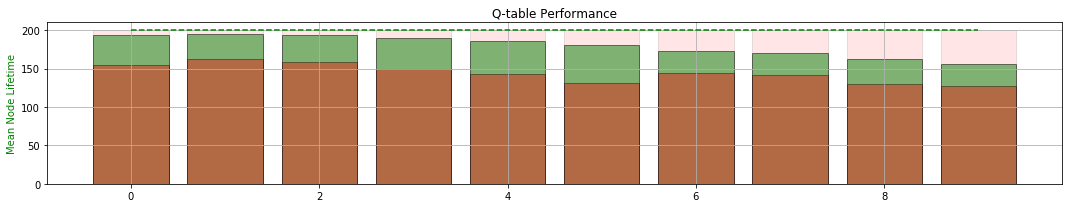

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8346
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.035
Validating... MEAN TIME:  193.435
Validating... MEAN TIME:  186.92
Validating... MEAN TIME:  194.24
Validating... MEAN TIME:  162.97
TRAINING TIME:0:00:45.934357


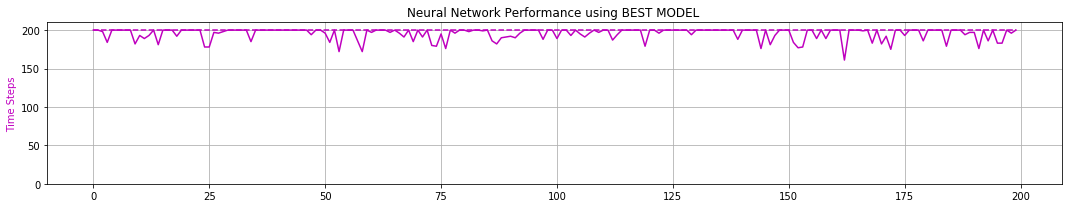

0 -max- [ 2.399  2.238  0.129  1.678  0.550]
0 -min- [-2.399 -3.010 -0.139 -0.836  0.375]

1 -max- [ 2.400  2.236  0.132  1.331  0.599]
1 -min- [-2.400 -2.797 -0.150 -1.032  0.400]

2 -max- [ 2.384  2.072  0.134  1.515  0.650]
2 -min- [-2.397 -3.022 -0.154 -0.897  0.451]

3 -max- [ 1.314  1.336  0.102  1.615  0.700]
3 -min- [-2.399 -2.989 -0.165 -0.945  0.500]

4 -max- [ 0.200  0.636  0.107  1.715  0.750]
4 -min- [-2.400 -3.199 -0.153 -0.993  0.551]

5 -max- [ 0.198  0.942  0.066  1.598  0.799]
5 -min- [-2.400 -3.019 -0.153 -1.389  0.601]

6 -max- [ 0.129  0.631  0.081  1.521  0.850]
6 -min- [-2.400 -3.153 -0.161 -0.988  0.650]

7 -max- [ 0.188  0.633  0.083  1.584  0.900]
7 -min- [-2.400 -3.121 -0.161 -0.993  0.701]

8 -max- [ 0.132  0.632  0.109  1.611  0.925]
8 -min- [-2.399 -3.127 -0.170 -1.046  0.751]

9 -max- [ 0.119  0.763  0.111  1.504  0.925]
9 -min- [-2.399 -3.121 -0.164 -1.112  0.800]

peak memory: 12574.01 MiB, increment: 10196.51 MiB
Quantization TIME:  0.1 minutes


ITERA

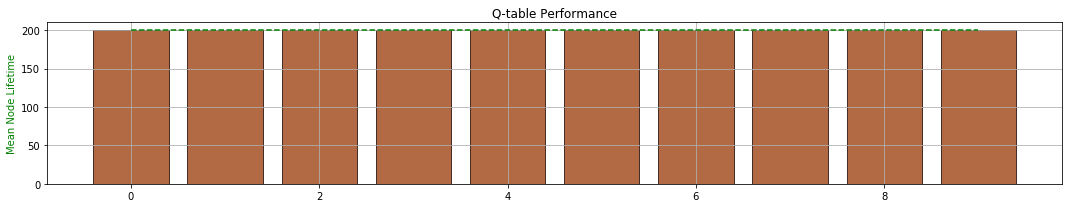

In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
#         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
#                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

    node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                        [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                        [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
        ###############################################
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

    # SAVE QFILE
    np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1761.0
Total Serial Timesteps   :  1259103.0
Speed-up                 :  714.99


In [21]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [22]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   161 SUCCESS 200   9    1761    1259103     714.99
